In [48]:
import numpy as np
import tensorflow as tf

In [49]:
def integration_task(seq_len, num_samples):
  for i in range(num_samples):
    rnd_noise = np.random.normal(size=seq_len)
    rnd_noise = np.expand_dims(rnd_noise,-1)
    target = np.sum(rnd_noise)
    if target >= 1:
      target = 1
    else: target = 0
    target = np.expand_dims(target,-1)
    yield rnd_noise, target

In [50]:
r = integration_task(5, 5)
for i in r:
  print(i)
  break

(array([[ 2.25567896],
       [ 0.70427505],
       [-1.40509897],
       [ 0.400284  ],
       [-2.09034243]]), array([0]))


In [51]:
def my_integration_task():
  seq_len = 10
  num_samples = 80000
  iter = integration_task(seq_len, num_samples)
  for x,y in iter:
    yield x,y

In [52]:
train_ds = tf.data.Dataset.from_generator(my_integration_task, (tf.float32, tf.int16))
test_ds = tf.data.Dataset.from_generator(my_integration_task, (tf.float32, tf.int16))

In [53]:
for elem in train_ds:
  print(elem)
  break

(<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[ 0.43794882],
       [ 0.51837295],
       [-0.35790887],
       [ 0.9794736 ],
       [-0.15092248],
       [ 0.60882974],
       [-2.0884836 ],
       [ 0.83173233],
       [-0.43273157],
       [ 1.525669  ]], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=int16, numpy=array([1], dtype=int16)>)


In [54]:
def prepare_LSMT_data(lsmt):
  lsmt = lsmt.cache()
  #shuffle, batch, prefetch
  lsmt = lsmt.shuffle(1000)
  lsmt = lsmt.batch(64)
  lsmt = lsmt.prefetch(20)
  #return preprocessed dataset
  return lsmt

In [55]:
train_dataset = train_ds.apply(prepare_LSMT_data)
test_dataset = test_ds.apply(prepare_LSMT_data)

In [56]:
class LSTM_Cell(tf.keras.layers.Layer):
  def __init__(self, units = 256):
    super(LSTM_Cell, self).__init__()
    self.units = units
    self.dense_sigmoid_1 = tf.keras.layers.Dense(self.units, activation = tf.nn.sigmoid, bias_initializer='ones')
    self.dense_sigmoid_2 = tf.keras.layers.Dense(self.units, activation = tf.nn.sigmoid)
    self.dense_sigmoid_3 = tf.keras.layers.Dense(self.units, activation = tf.nn.sigmoid)
    self.dense_tanh_1 = tf.keras.layers.Dense(self.units, activation = tf.nn.tanh)
    

  def call(self, input_single_time_step, states):
    h_s, c_s = states
    
    concat = tf.concat([input_single_time_step, h_s], 1)
    
    x_1 = self.dense_sigmoid_1(concat)

    x_2 = self.dense_sigmoid_2(concat)
    
    x_3 = self.dense_tanh_1(concat)
    
    sig_and_tan = tf.math.multiply(x_2,x_3)

    c_t = tf.math.multiply(x_1, c_s) +\
                 tf.math.multiply(x_2, x_3)
    
    x_4 = self.dense_sigmoid_3(concat)
    
    acti = tf.nn.tanh(c_t)
    
    h_t = tf.math.multiply(x_4, acti)

    return h_t,c_t
  


In [57]:
class LSTM_Layer(tf.keras.layers.Layer):
  def __init__(self, cell_units = 1):
    super(LSTM_Layer, self).__init__()
    
    self.units = cell_units
    self.cell = LSTM_Cell(self.units)
    self.zeros = self.zero_states(64)

  def call(self, inputs, states=None):
      if states == None:
          states = self.zeros
      output_sequence = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
      
      for i in tf.range(10):
          input = inputs[:, i]
          states = self.cell(input, states)
          output_sequence = output_sequence.write(i, states[0])
      output_sequence = tf.transpose(output_sequence.stack(), perm=[1,0,2])
      
      return output_sequence

  def zero_states(self, batch_size):
        return (tf.zeros((batch_size, self.cell.units)), tf.zeros((batch_size, self.cell.units)))



  

In [58]:
class LSTM(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.layer_list = [
                           tf.keras.layers.Dense(50, activation='sigmoid'),
                           LSTM_Layer(cell_units=6),
                           tf.keras.layers.Dense(3, activation='sigmoid'),
                           tf.keras.layers.Dense(1, activation='sigmoid')
                           ]

    def call(self, x):
        input = x
        for layer in self.layer_list:
            input = layer(input)    
        return input[:,-1,:]


In [59]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.round(target) == np.round(prediction)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [60]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Initialize the model.
model = LSTM()
# Initialize the loss: binary cross entropy. Check out 'tf.keras.losses'.
binary_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, binary_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, binary_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, binary_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, binary_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.6237625
Epoch: 1 starting with accuracy 0.957775
Epoch: 2 starting with accuracy 0.9752125
Epoch: 3 starting with accuracy 0.9726625
Epoch: 4 starting with accuracy 0.9863625
Epoch: 5 starting with accuracy 0.988725
Epoch: 6 starting with accuracy 0.9821875
Epoch: 7 starting with accuracy 0.9879375
Epoch: 8 starting with accuracy 0.9770875
Epoch: 9 starting with accuracy 0.984675


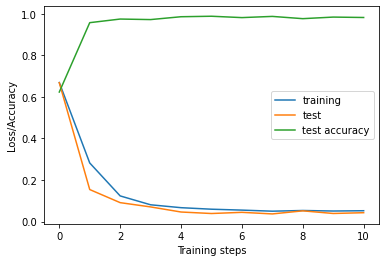

In [61]:
import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training","test", "test accuracy"))
plt.show()